# <div style="text-align: center">18.335/6.337 Midterm Exam [25 pts in total]</div>
## <div style="text-align: center">Solutions</div>

### <div style="text-align: right">Creaed by Wonseok Shin</div>

$\newcommand{\Cmat}[2]{\mathbb{C}^{#1\times#2}}\newcommand{\Cvec}[1]{\mathbb{C}^{#1}}\newcommand{\Rmat}[2]{\mathbb{R}^{#1\times#2}}\newcommand{\Rvec}[1]{\mathbb{R}^{#1}}\newcommand{\null}{\mathrm{null}}\newcommand{\range}{\mathrm{range}}\newcommand{\rank}{\mathrm{rank}}\newcommand{\nullity}{\mathrm{nullity}}\newcommand{\sign}{\mathrm{sign}}\newcommand{\norm}[1]{\left\|#1\right\|}\newcommand{\abs}[1]{\left|#1\right|}\newcommand{\epsmach}{\epsilon_\mathrm{machine}}\newcommand{\log}{\mathrm{log}}\newcommand{\tanh}{\mathrm{tanh}}\newcommand{\l}{\lambda}\newcommand{\d}{\delta}$

## Instructions for submission
- As usual, please archive all files (this Jupyter notebook plus other files if any) into a single ZIP file and upload it to the course website.
- No late submission will be accepted, so please attempt to submit the first version at least 30 minutes before the submission deadline.
- Once you submit your final solution, please make sure to download it yourself to check if it is the version you intend to submit.  (If you realize later that you've uploaded a wrong file, we will not accept late submission of the correct file, and the score of the wrong file will be your midterm exam score.) 
- In case of any technical difficulties during submission, send your solution file directly to the instructor (`wsshin@mit.edu`).

## Function definitions

The following functions are taken from previous problem sets because they are used in this midterm exam.

In [1]:
function house!(V, A)
    assert(size(V)==size(A))
    
    m, n = size(A)

    for k = 1:n
        x = @view A[k:m, k]
        
        # Construct sign(x₁) for exp(iθ) = -sign(x₁).
        s = sign(x[1])
        if s == 0
            s = 1.
        end

        # Construct the kth Houreholder reflection vector.
        v = @view V[k:m, k]
        copy!(v, x)
        lx = norm(x)
        slx = s * lx
        v[1] = v[1] + slx
        
        # Perform the Householder reflection to triangularize the kth column of A.
        lv = norm(v)
        if lv ≠ 0
            v ./= lv
            
            # Take care of the kth column of A.
            A[k+1:m, k] .= 0
            A[k,k] = -slx
            
            # Take care of the remaining columns of A.
            if k < n
                A[k:m, k+1:n] .-= v * (2(v' * @view A[k:m, k+1:n]))
            end
        end
    end
end

# applyQ! is simplified from Problem Set 3 and is capable to apply only Q rather than Q*.
function applyQ!(V, X)
    m, n = size(V)
    assert(size(X,1) == m)

    for k = n:-1:1
        v = @view V[k:m, k]
        X[k:m,:] .-= v * (2(v' * @view X[k:m,:]))
    end
end

applyQ! (generic function with 1 method)

## Problem 1.  Volume of a frustum [4 pts]

Consider a plane intersecting a cube.  The cube is divided into two volumes by the plane. Suppose that the intersection is such that the smaller of the two volumes is a frustum (the colored region in the figure below) whose top and bottom bases are right-triangular.  The four black dots in the figure indicate where the plane intersects the edges of the cube.  The goal of this problem is to find a formula for the volume of this frustum.

<img src="frustum.pdf">

Here are geometric parameters and some conditions:

- $h$ is the edge of the cube, so it is the height of the frustum.
- $a$ and $b$ are the two sides of the bottom base adjacent to the right angle.  $a \le h$ and $b \le h$.
- $c$ and $d$ are the two sides of the top base adjacent to the right angle.
    - Because the top and bottom bases are similar, $d = \frac{b}{a} c$.
    - For simplicity, assume $c \le a$.  (The top base is less than or equal to the bottom base.)

(a) [1 pt] The volume can be calculated as the difference between the volumes of two pyramids.  In doing so, what numerical issue do you expect in what situation?  Describe the situation in words in terms of the geometric parameters given above.

***Solution***.

In the figure, extend $h$ upward and find its intersection with our plane.  Imagine two triangular pyramids that share this intersection point as the apex: the one whose base is the top base of the frustum and the other whose base is the bottom base of the frustum.  The volume of the frustum can be calculated by subtracting the volume of the former from the volume of the latter.

Such subtraciton suffers from two numerical issues when the plane is nearly parallel to $h$ (or when $c \to a$):
- catastrophic cancellation, because the volumes of the two pyramids become very close, and 
- overflow, because the volumes of both pyramids become infinitely large.

(b) [2 pts] Derive a numerically stable formula for the volume of the frustum that avoids the numerical issue you described in Part (a).

***Solution***.

Let $H$ be the height of the larger pyramid.  Because the two pyramids are similar, the volume of the frustum is

$$
V = \frac{1}{6} a b H \left[1-\left(\frac{c}{a}\right)^3\right] = \frac{1}{6} a b H \left(1-\frac{c}{a}\right) \left[1 + \frac{c}{a} + \left(\frac{c}{a}\right)^2 \right].
$$

When $c \to a$, the factor $H \left(1-\frac{c}{a}\right)$ suffers from catastrophic cancellation.  However, we do not need to evaluate this factor numerically, because it is nothing but $h$.  Therefore, the volume of the fustum is

$$
V = \frac{1}{6} a b h \left[1 + \frac{c}{a} + \left(\frac{c}{a}\right)^2 \right].
$$

Note that this formula suffers from neither catastrophic cancellation nor overflow.

(c) [1 pt] Complete `vol_frustum` below that takes $a$, $b$, $c$, $h$ and returns the volume of the frustum using the formula derived in Part (b).

***Solution***.

The implementation is easy:

In [32]:
function vol_frustum(a, b, c, h)
    r = c/a
    vol = a*b*h*(1+r+r^2) / 6
    
    return vol
end

vol_frustum (generic function with 1 method)

The following is not required by this problem, but just for fun, let's compare this numerically stable formula with the obvious formula, whic directly subtracts the smaller pyramid volume from the larger one:

In [33]:
function vol_frustum_obvious(a, b, c, h)
    H = h / (1-c/a)
    d = (b/a) * c
    v = c*d*(H-h) / 6
    V = a*b*H / 6

    vol = V - v
    
    return vol
end

vol_frustum_obvious (generic function with 1 method)

Now, consider a case where $h = a = b = 1$ and $c$ is slightly less than $a$, say $1-10^{-9}$.  The frustum volume must be less than $0.5$, but the obvious formula returns $0.5$: 

In [34]:
vol_frustum_obvious(1,1,1-1e-9,1)

0.5

On the other hand, the numerically stable formula correctly returns a value less than $0.5$:

In [35]:
vol_frustum(1,1,1-1e-9,1)

0.49999999949999996

## Problem 2.  Accurate evaluation of an infinite series [4 pts]

Consider an infinite series $s = \sum_{k=1}^{\infty} \frac{1}{k^4}$.  The goal of this problem is to find the approximate value $\hat{s}$ of $s$ with double-precision accuracy (i.e., $\hat{s} = \mathrm{fl}(s)$).

The terms in the series decrease quickly to 0.  Therefore, the truncated series $s_n = \sum_{k=1}^{n} \frac{1}{k^4}$ would be a good approximation of the infinite series $s$ for sufficiently large $n$.

(a) [2 pts] Find $n$ for which $s_n$ is a double-precision-or-more accurate approximation of $s$.  Use the following hints:
- The error is $s - s_n = \sum_{k=n+1}^{\infty} \frac{1}{k^4}$.  How small must this error be to achieve the desired accuracy in $s_n$?
- What is a close upper bound of the error $s - s_n$?  Can you find one as the area under some curve, which can be calculated by a definite integral?

***Solution***.

Fon $s_n$ to be a double-precision-or-more accurate approximation of $s$, $\abs{s - s_n}$ needs to be less than $\epsmach=\mathrm{eps()}/2$.

From the following figure, we have 
$$
s - s_n = \sum_{k=n+1}^{\infty} \frac{1}{k^4}<\int_{n}^{\infty}\frac{1}{x^4} dx = \frac{1}{3n^3}.
$$

Therefore, to guarantee $s - s_n < \epsmach$, we need to have $1/3n^3 < \epsmach$, or $n > 1/(3 \epsmach)^{1/3}=144263.40\cdots$ equivalently.  Because $n$ is an integer, we conclude that $n$ needs to be at least $144264$.

Of course, $1/3n^3$ in the above argument is a loose upper bound of $s-s_n$, so $s-s_n < \epsmach$ can be achieved for smaller $n$.  However, $n$ different from $144264$ will be accepted as a valid solution only if it is proved that $s - s_n < \epsmach$ for such $n$.

<img src="x⁻⁴.pdf">



(b) [2 pts] In fact, $s = \frac{\pi^4}{90}$ exactly (see [here](https://en.wikipedia.org/wiki/Riemann_zeta_function#Specific_values)), so the desired $\hat{s}$ is nothing but the floating-point representation of $\frac{\pi^4}{90}$. 

Now, the function `s_truncated` below takes `n` as an argument and evaluates the truncated series $s_n$.  You may expect that `s_truncated` would return $\hat{s}$ if $n$ obtained in Part (a) is used as the argument, but you can verify that is not the case using the subsequent code block.

Change one line of `s_truncated` to make it evaluate $s_n$ more accurately.  Briefly explain in words why your change makes `s_truncated` more accurate.  (Hint.  Which one is more accurate: `(2 + eps()) + eps()` or `2 + (eps() + eps())`?)

After this change, you will see that `s_truncated` for $n$ obtained in Part (a) returns $\hat{s}$.

***Solution***.

When two positive double-precision floating-point numbers $x_1 = m_1 \beta^{e_1}$ and $x_2 = m_2 \beta^{e_2}$ with $e_1 > e_2$ are added, they are first added in infinite precision as

$$
x_1 + x_2 = (m_1 + m_2 \beta^{e_2-e_1}) \beta^{e_1},
$$

and the result is approximated by a floating point number.  During this approximation, only the leading 53 bits of the mantissa are kept.  Therefore, many least-significant mantissa bits in $m_2$ are lost.  The greater the difference between $e_1$ and $e_2$ is, the more the mantissa bits are lost.  

If we evaluate $\sum_{k=1}^n 1/k^4$ in the obvious order, for some $m < n$ the partial sum $s_m = \sum_{k=1}^m 1/k^4$ becomes much greater than the next term $1/(m+1)^4$ to add, and therefore many least-significant mantissa bits in $1/(m+1)^4$ are lost during addition.  Though these lost mantissa bits are the least significant bits and therefore constitute a small amount, such loss occurs for all the $\frac{1}{k^4}$ terms for $k > m$ and is accumulated, leading to a noticeable difference in the final sum.

Therefore, to avoid losing the least-significant mantissa bits of the addends, it is important to keep the partial sum as small as possible during summation (so that it is not too much greater than the next term to add), which is achieved by adding the smallest terms first.  For $s_n = \sum_{k=1}^n 1/k^4$, this means we need to add the terms in the reverse order as in the following modified `s_trucated`.

Note that this technique only works when we know the number of terms to add in advance: we cannot reverse the order of addition in the infinite sum $s = \sum_{k=1}^{\infty} 1/k^4$ because it does not have the last term.  This is why we needed to estimate $n$ in Part (a).

In [51]:
function s_truncated(n)
    s = 0.0
    for k = n:-1:1  # use this instead of k = 1:n
        s += 1.0/float(k)^4
    end
    
    return s    
end

s_truncated (generic function with 1 method)

In [52]:
n = ceil(1/(3eps()/2)^(1/3))  # use your n obtained in Part (a)
ŝₙ = s_truncated(n)
ŝ = π^4 / 90
ŝ - ŝₙ

0.0

## Problem 3.  Explicit formation of $Q$ of the Householder QR factorization [5 pts]

In Problem Set 3, we wrote `house!` that performs the Householder QR factorization on $A \in \Cmat{m}{n}$ with $m \ge n$.  We also wrote `applyQhouse!`, which is renamed `applyQ!` for simplicity here, that applies $Q$ implicitly to $X \in \Cmat{m}{p}$ with arbitrary positive integer $p$.  (For convenience, these functions are defined in the beginning of this notebook file.)

If we need to form $Q$ explicitly, we can use `applyQ!` on $X = I \in \Cmat{m}{m}$.  However, it is possible to form $Q$ faster than that.  The goal of this problem is to create `formQ!` that implements this faster method.

### Assignment 3.1.  `formQ!` [2 pts]

The second argument $X$ of `applyQ!` can be any matrix as long as it has the same number of rows as the first argument $V$.  However, $X = I$ passed to `applyQ!` to form $Q$ is not an arbitrary matrix, but a very sparse matrix.  

Devise an algorithm that exploits this sparsity of $I$ to form $Q$ faster than naively using `applyQ!` on $I$.  Complete `formQ!` below that implements this new algorithm.  (It is not much different from `applyQ!`.)  For this part, you do not need to explain your algorithm because the code speaks for itself.

`formQ!` takes two input arguments `V` and `Q`:
- `V` is produced by `house!`, and
- `Q` is assumed to be the square identity matrix with the same number of rows as `V` (i.e., $Q = I \in \Cmat{m}{m}$ for $V \in \Cmat{m}{n}$).

After execution of `formQ!(V, Q)`,
- `V` remains the same as before, and
- `Q` stores the explicitly formed $Q$ factor of the Householder QR factorization.

`formQ!` does not need to `return` anything, because the outputs are stored in the input arguments.

***Solution***.

We have $Q = Q_1 \cdots Q_n$.  In `applyQ!`, $Q X = Q_1 \cdots Q_n X$ is calculated by executing

$$
X_{k:m,:} = X_{k:m,:} - \hat{v}_k (2(\hat{v}_k^* * X_{k:m,:}))
$$

in the order of $k = n, \ldots, 1$.  

`formQ!` also needs to calculate $Q_1 \cdots Q_n X$ using the above formula, but this time $X = I$.  This allows us to replace $X_{k:m,:}$ with $X_{k:m,k:m}$ in the above formula, because starting with $X = I$ ensures $X_{k:m,1:k-1} = 0$ at each step $k$.  For example, for $m = 4$ and $n = 3$, $X$ changes as follows:

$$
\left[\begin{array}{cccc}
1 &   &   &  \\
  & 1 &   &  \\
  &   & 1 &  \\
  &   &   & 1\\
\end{array}\right]\overset{Q_3}{\longrightarrow}
\left[\begin{array}{cccc}
1 &   &   &  \\
  & 1 &   &  \\
  &   & \times & \times\\
  &   & \times & \times\\
\end{array}\right]\overset{Q_2}{\longrightarrow}
\left[\begin{array}{cccc}
1 &   &   &  \\
  & \times & \times & \times\\
  & \times & \times & \times\\
  & \times & \times & \times\\
\end{array}\right]\overset{Q_1}{\longrightarrow}
\left[\begin{array}{cccc}
\times & \times & \times & \times\\
\times & \times & \times & \times\\
\times & \times & \times & \times\\
\times & \times & \times & \times\\
\end{array}\right]
$$

Considering this, `formQ!` can be implemented as follows:

In [8]:
function formQ!(V, Q)
    m, n = size(V)
    assert(size(Q) == (m,m))
    
    for k = n:-1:1
        v = @view V[k:m,k]
        Q[k:m,k:m] .-= v * (2(v' * @view Q[k:m,k:m]))
    end
end

formQ! (generic function with 1 method)

### Assignment 3.2.  `formQ!` vs. `applyQ!` [3 pts]

Now, let's see how fast `formQ!` is compared to `applyQ!`.

(a) [2 pts] Let's compare the costs for the two operations in terms of the number of flops.
- Derive the asymptotic number of flops needed for executing `formQ!` for $V \in \Rmat{m}{n}$.  (We consider real matrices, because we will perform numerical experiments for them later.)  
- Derive the asymptotic number of flops needed for forming $Q$ explicitly using `applyQ!`.
- Comparing the numbers of flops, how much speedup do you expect to get by using `formQ!` instead of `applyQ!`?  Answer this question by expressing the speedup factor as a function of $n/m$, and implement it as a Julia function `spdup_flop(rnm)` below, where `rnm` is the ratio $n/m$.
- In what condition is the speedup factor maximized to what value?

***Solution***.

For each $k$, for each column $q$ of $Q_{k:m,k:m}$, `formQ!` spends

- $m-k+1$ multiplications and $m-k$ additions for $\alpha = \hat{v}_k^* q$,
- $1$ scalar multiplication for $\beta = 2\alpha$, 
- $m-k+1$ multiplications for $w = \hat{v}_k \beta$,
- $m-k+1$ subtractions for $q = q-w$,

which are $4(m-k+1)$ flops in total.  Because $Q_{k:m,k:m}$ has $m-k+1$ columns and $k$ runs from $n$ down to $1$, the total number of flops taken by `formQ!` is

$$
\sum_{k=n}^1 4(m-k+1)^2 = \sum_{j=m-n+1}^m 4j^2 \sim \frac{4}{3} \left[m^3 - (m-n)^3\right].
$$

`applyQ!` also spends $4(m-k+1)$ flops for each column $x$ of $X_{k:m,:}$ for each $k$.  Because $X = I$, $X_{k:m,:}$ has $m$ colums.  Therefore, the total number of flops taken by `applyQ!` is

$$
\sum_{k=n}^1 4(m-k+1)m = \sum_{j=m-n+1}^m 4mj \sim 2 m \left[m^2 - (m-n)^2\right].
$$

Comparing the two results, we expect a speedup factor of

$$
\frac{2 m \left[m^2 - (m-n)^2\right]}{\frac{4}{3} \left[m^3 - (m-n)^3\right]} = \frac{3}{2} \left[\frac{1 - (1-\frac{n}{m})^2}{1 - (1-\frac{n}{m})^3}\right]
$$

by using `formQ!` instead of `applyQ!`.

To find out when the speedup factor is maximized, define $s = 1-n/m$.  Then, the above speedup factor satisfies

$$
\frac{3}{2} \left(\frac{1 - s^2}{1 - s^3}\right) = \frac{3}{2} \frac{1 + s}{1 + s + s^2}= \frac{3}{2} \frac{1}{\left[(1 + s) + \frac{1}{1+s}\right] - 1} \le \frac{3}{2} \frac{1}{2 - 1} = 1.5
$$

from the [AM–GM inequality](https://en.wikipedia.org/wiki/Inequality_of_arithmetic_and_geometric_means), and the equality holds when $1 + s = \frac{1}{1+s}$, or $n = m$ equivalently.  Therefore, we get the maximum speedup factor of $1.5$ when $n = m$.

In [9]:
spdup_flop(rnm) = 1.5 * (1-(1-rnm)^2) / (1-(1-rnm)^3)

spdup_flop (generic function with 1 method)

(b) [1 pt] Complete `spdup_time` below that measures the actual speedup factor for a given $V$ by numerical experiment.  
- To measure the actual speedup factor, take the ratio between the times taken for `formQ!` and `applyQ!`.  (Use `@elapsed`.)
- Because computation time fluctuates wildly from execution to execution, perform $N = 20$ measurments of this ratio and return the median value to ignore outliers.

You can compare the theoretical speedup factor obtained in Part (a) with the actual measurement by `spdup_time` using the subsequent code block.

In [10]:
function spdup_time(V)
    N = 20
    rt = Vector{Float64}(N)

    T = eltype(V)
    I = eye(T, m)
    for k = 1:N
        fill!(I, 0)
        I[diagind(I)] = 1        
        t_apply = @elapsed applyQ!(V, I)

        fill!(I, 0)
        I[diagind(I)] = 1
        t_form = @elapsed formQ!(V, I)
        
        rt[k] = t_apply / t_form
    end
    
    return median(rt)
end    

spdup_time (generic function with 1 method)

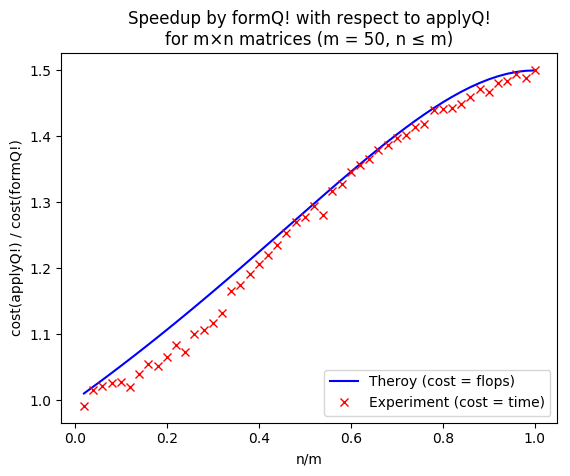

PyObject <matplotlib.legend.Legend object at 0x3154694a8>

In [11]:
m = 50
nmax = m

A = rand(m, nmax)
V = zeros(size(A))
house!(V, A)

st = Vector{Float64}(nmax)
for n = 1:nmax
    st[n] = spdup_time((@view V[:,1:n]))
end

using PyPlot
rnm = (1:nmax) ./ m

plot(rnm, spdup_flop.(rnm), "b-", rnm, st, "rx")
title("Speedup by formQ! with respect to applyQ!\nfor m×n matrices (m = $m, n ≤ m)")
xlabel("n/m")
ylabel("cost(applyQ!) / cost(formQ!)")
legend(["Theroy (cost = flops)", "Experiment (cost = time)"], loc="lower right")

## Problem 4.  Point with the least root-mean-square distance from affine subspaces [6 pts]

For given $A \in \Cmat{m}{n}$ and $p \in \Cvec{m}$, consider the following set of points:

$$
F = \{p + A x \mid x \in \Cvec{n} \}
$$

$F$ is called an affine subspace of $\Cvec{m}$, and it is nothing but a subspace $\range(A)$ translated by some vector $p$.  Unlike subspaces, affine subspaces do not necessarily contain the origin.  For example, a plane away from the origin is an affine subspace in 3D.

Like you measure the distance from a point to a plane in 3D, you can measure the distance from a point to an affine subspace.  The distance from $z \in \Cvec{m}$ to an affine subspace $F$ is defined by the distance between $z$ and the closest point in $F$, i.e.,

$$
d = \min_{f \in F} \norm{z - f},
$$

where $\norm{\cdot}$ is the 2-norm.

Now, suppose that we have $k$ affine subspaces $F_1, \ldots, F_k$ of $\Cvec{m}$ defined by points $p_1, \ldots, p_k \in \Cvec{m}$ and matrices $A_1, \ldots, A_k$.  (all the $A_i$'s have $m$ rows, but they do not necessarily have the same number of columns, i.e., $A_1 \in \Cmat{m}{n_1}, \ldots, A_k \in \Cmat{m}{n_k}$.)  The goal of this problem is to find the point $z$ that minimizes the root-mean-square (RMS) distance  to these affine spaces.  In other words, we want to find $z$ minimizing

$$
d_\mathrm{rms} = \sqrt{\frac{1}{k}\sum_{i=1}^k d_i^2},
$$

where $d_i = \min_{f \in F_i} \norm{z - f}$.

(a) [3 pts] For given $p_1, \ldots, p_k$ and $A_1, \ldots, A_k$, explain how to find such $z$ and corresponding $d_\mathrm{rms}$ by solving a least squares problem.  For simplicity, assume that the columns of each $A_i$ are orthonormal.

***Solution***.

We can derive the closed-form formula for each $d_i$.  For given $z$, 

$$
d_i = \min_{f \in F_i} \norm{z - f} = \min_{x \in \Cvec{n}} \norm{(z - p_i) - A_i x},
$$

where $x$ minimizing the last expression is the solution to a least squares problem and therefore is $x = (A_i^* A_i)^{-1} A_i^* (z-p_i) = A_i^* (z-p_i)$.  Hence,

$$
d_i = \norm{(z-p_i) - A_i A_i^* (z-p_i)} = \norm{(I - A_i A_i^*) (z-p_i)}.
$$

This makes sense geometrically.  $A_i A_i^*$ is the orthogonal projector *onto* $\range(A_i)$, so $I - A_i A_i^*$, which is the complementary projector of $A_i A_i^*$, is the orthogonal projector *along* $\range(A_i)$.  Because $z-p_i$ is the vector connecting $z$ and a point $p_i$ on the affine space, $(I - A_i A_i^*) (z-p_i)$ is the component of $z-p_i$ perpendicular to the affine space, and thus its length is the distance from $z$ to the affine space.

Using the above formula for $d_i$, we can write

$$
k^2 d_\mathrm{rms} = \sum_{i=1}^k d_i^2 = \norm{\left[
\begin{array}{c}
 (I - A_1 A_1^*) (z-p_1) \\
 \vdots  \\
 (I - A_k A_k^*) (z-p_k) \\
\end{array}
\right]}^2 =
\norm{\left[
\begin{array}{c}
 I - A_1 A_1^* \\
 \vdots  \\
 I - A_k A_k^* \\
\end{array}
\right] z - \left[
\begin{array}{c}
 (I - A_1 A_1^*) p_1 \\
 \vdots  \\
 (I - A_k A_k^*) p_k \\
\end{array}
\right]}^2.
$$

$z$ minimizing the last expression can be obtained by solving the least squares problem whose matrix $A$ and right-hand side vector $b$ are

$$
A = \left[
\begin{array}{c}
 I - A_1 A_1^* \\
 \vdots  \\
 I - A_k A_k^* \\
\end{array}
\right],\quad b = \left[
\begin{array}{c}
 (I - A_1 A_1^*) p_1 \\
 \vdots  \\
 (I - A_k A_k^*) p_k \\
\end{array}
\right],
$$

and the minimim $d_\mathrm{rms}$ can be easily obtained using this $z$.

(b) [1 pt] When does the matrix of your least squares problem in Part (a) become rank-deficient that you need to solve it via SVD?  Describe the condition in terms of $A_1, \ldots, A_k$.

***Solution***.

The matrix $A$ in the solution to Part (a) is skinny.  Therefore, it becomes rank-deficient when its nullspace has a nonzero vector as an element.

$A$ has $v \neq 0$ in its nullspace if and only if $(I - A_i A_i^*) v = 0$ for all $i = 1, \ldots, k$.  Therefore, $A$ becomes rank-deficient if and only if there is a nonzero vector shared by the nullspaces of all $I - A_i A_i^*$'s.

Note that $I - A_i A_i^*$ is an orthogonal projector *along* $\range(A_i)$, so its nullspace is nothing but $\range(A_i)$.  Therefore, we conclude that $A$ becomes rank-deficient if and only if there is a nonzero vector shared by $\range(A_i)$'s.

(c) [2 pts] Assuming the given $A_1, \ldots, A_k$ do not fall into the case described in Part (b), complete `pt_min_drms` below that takes an array of $p_i$'s and an array of $A_i$'s and returns $z$ and $d_\mathrm{rms}$.  

Execute the subsequent code block to check if your function runs without errors.  (This is just to detect syntax errors.)

In [53]:
function pt_min_drms(p, A)
    # p[1], p[2], ... are pᵢ's, and A[1], A[2], ..., are Aᵢ's.
    
    k = length(p)
    assert(length(A) == k)
    m = size(A[1], 1)
    
    T = eltype(p[1])
    
    # Construct the matrix (Atot) and vector (btot) of the least squares problem.
    I = eye(T, m)
    Atot = Matrix{T}(k*m, m)
    btot = Vector{T}(k*m)
    for i = 1:k
        P = I - A[i]*A[i]'  # individual orthogonal projector

        ind0 = 1+(i-1)*m
        ind1 = i*m
        
        Atot[ind0:ind1, :] = P
        btot[ind0:ind1] = P * p[i]
    end
    
    # Find the d_rms-minimizing point z and the corresponding d_rms.
    z = Atot \ btot
    drms = norm(btot - Atot*z) / sqrt(k)
    
    return z, drms
end

pt_min_drms (generic function with 1 method)

In [54]:
using JLD
@load "pA.jld"

z, drms = pt_min_drms(p, A)

println("z = [")
for zi = z
    println("\t$zi")
end
println("]\n")
println("d_rms = $drms\n")

z = [
	0.42946161321334936 + 0.41552749863761124im
	0.528634090375491 + 0.4211799505562526im
	0.4699021253109107 + 0.4322522670737496im
	0.4918664675439409 + 0.5012237014956257im
]

d_rms = 0.5631677852242845



## Problem 5.  Intersection between subspaces [6 pts]

In this problem, we will develop a method to calculate the intersection between two subspaces $\range(A)$ and $\range(B)$ for $A \in \Cmat{m}{n}$ and $B \in \Cmat{m}{p}$.

To begin with, here are a few facts you must have learned in linear algebra class, just in case you forgot them.  Below, $X$ and $Y$ are subspaces of $\Cvec{m}$.

- $X^\bot = \{z \in \Cvec{m} \mid x^* z = 0 \text{ for all } x \in X\}$.  In other words, $X^\bot$ is the set of vectors orthogonal to all vectors in $X$.  It is called the [orthogonal complement](https://en.wikipedia.org/wiki/Orthogonal_complement) of $X$.
- $(X^\bot)^\bot = X$.
- $X + Y = \{x+y \mid x \in X, y \in Y\}$.  In other words, $X+Y$ is the set of vectors that can be decomposed into the sum of the elements of $X$ and $Y$.

(a) [1 pt] Show that $\range(A)^\bot = \null(A^*)$.

***Solution***.

$$
\begin{align}
\null(A^*) &=\{x \in \Cvec{m} \mid A^* x = 0\}\\
&= \{x \in \Cvec{m} \mid a_i^* x = 0 \text{ for all } i = 1, \ldots, n\}\\
&= \{x \in \Cvec{m} \mid a^* x = 0 \text{ for all } a \in \left<a_1, \ldots, a_n\right>\}\\
&= \{x \in \Cvec{m} \mid a^* x = 0 \text{ for all } a \in \range(A)\} = \range(A)^\bot.
\end{align}
$$

(b) [1 pt] Complete the function `null` below that takes an arbitrary matrix $A$ and returns orthonormal basis vectors of the nullspace of $A$.  (Hint.  Full SVD can be performed by `svd(A, thin=false)` in Julia.)

***Solution***.

From Theorem 5.2 of Trefethen and Bau, we know that the right singular vectors corresponding to zero singular values are orthonormal basis vectors of $\null(A)$.  This is used to implement `null` below:

In [56]:
function null(A)
    m, n = size(A)
    ~, σ, V = svd(A, thin=false)    
    r = findlast(σ .> 0)  # index of last nonzero singular value
    
    return V[:, r+1:n]
end

null (generic function with 1 method)

(c) [2 pts] For subspaces of $X$ and $Y$ of $\Cvec{m}$, show $(X + Y)^\bot = X^\bot \cap Y^\bot$.  (Hint.  For a basis $\{a_1, \ldots, a_k\}$ of $X$, $X = \range(A)$.)

***Solution***.

For bases $\{a_1, \ldots, a_k\}$ and $\{b_1, \ldots, b_n\}$ of $X$ and $Y$, we have $X = \range(A)$ and $Y = \range(B)$.  Then, $X + Y = \left<a_1, \ldots, a_k, b_1, \ldots, b_n \right> = \range(\left[A\,\, B\right])$.  Therefore, using Part (a), we have

$$
\begin{align}
(X + Y)^\bot & = \range(\left[A\,\, B\right])^\bot\\
& = \null(\left[A\,\, B\right]^*)\\
& = \null\left(\left[
\begin{array}{c}
 A^* \\
 B^* \\
\end{array}
\right]\right)\\
& = \{x \mid A^* x = 0 \text{ and } B^*x = 0\}\\
& = \null(A^*) \cap \null(B^*)\\
& = \range(A)^\bot \cap \range(B)^\bot = X^\bot \cap Y^\bot.
\end{align}
$$


(d) [2 pts] Suppose $A \in \Cmat{m}{n}$ and $B \in \Cmat{m}{p}$ are full-rank and skinny, where $n$ and $p$ are not necessarily the same.  Complete `interspace` below that takes $A$ and $B$ and returns $\range(A) \cap \range(B)$.  Use `null` three times, and do not perform any matrix factorization or orthogonalization outside `null`.

***Solution***.

Because $X^\bot \cap Y^\bot = (X + Y)^\bot$ from Part (c) and also $(X^\bot)^\bot = X$, we have 

$$
X \cap Y = (X^\bot)^\bot \cap (Y^\bot)^\bot = (X^\bot + Y^\bot)^\bot.
$$

Therefore,

$$
\range(A) \cap \range(B) = (\range(A)^\bot + \range(B)^\bot)^\bot = (\null(A^*) + \null(B^*))^\bot.
$$

Now, suppose that $\{c_1, \ldots, c_{m-n}\}$ and $\{c'_1, \ldots, c'_{m-p}\}$ are orthonormal bases of $\null(A^*)$ and $\null(B^*)$, respectively.  Then, for a matrix $C = \left[c_1\,\, \cdots\,\, c_{m-n}\,\, c'_1\,\, \cdots\,\, c'_{m-p}\right]$, we have $\null(A^*) + \null(B^*) = \range(C)$.  Therefore,

$$
\range(A) \cap \range(B) = \range(C)^\bot = \null(C^*).
$$




So, we can find an orthonormal basis of $\range(A) \cap \range(B)$ by following the procedure below:

- Find onthonormal bases $\{c_1, \ldots, c_{m-n}\}$ and $\{c'_1, \ldots, c'_{m-p}\}$ of $\null(A^*)$ and $\null(B^*)$ using `null` twice.
- Construct a matrix $C = \left[c_1\,\, \cdots\,\, c_{m-n}\,\, c'_1\,\, \cdots\,\, c'_{m-p}\right]$.
- Find an orthonormal basis of $\null(C^*)$ using `null` once.  Then the basis is an orthonormal basis of $\range(A) \cap \range(B)$.

`interspace` below implements this algorithm.

In [59]:
function interspace(A, B)
    Na = null(A')
    Nb = null(B')
    C = [Na Nb]
    
    return null(C')
end

interspace (generic function with 1 method)

Some of you might have noticed that this problem is a generalization of Prob. 2 of Problem Set 2.  The following code block verifies that `interspace` produces the same solution to that problem:

In [61]:
a₁ = [0.9, 0.3, 0.2]
a₂ = [0.5, 0.9, 0.6]

b₁ = [0.1, 0.6, 0.1]
b₂ = [0.7, 0.4, 0.6]

A = [a₁ a₂]
B = [b₁ b₂]

v = interspace(A, B)

println("Intersection is along v = $v.")

Intersection is along v = [0.534673; 0.703132; 0.468754].
